In [1]:
RANDOM_STATE = 42

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

## Сначала попробую максимально простой бейзлайн просто на трейновых данных без объединения.


In [2]:
df = pd.read_csv("../data/raw/car_train.csv")

target_col = "target_class"        
id_col = "car_id"                  

candidate_cat = ["model", "car_type", "fuel_type"]
candidate_num = ["car_rating", "riders", "year_to_start", "year_to_work"]



cat_cols = [c for c in candidate_cat if c in df.columns]
num_cols = [c for c in candidate_num if c in df.columns]



X = df.drop(columns=[col for col in [target_col, id_col] if col in df.columns])
y = df[target_col].astype("category")


Обоснование выбора Label Encoding для таргета

Для кодирования целевой переменной выбран LabelEncoder, так как он переводит категориальные метки классов в числовой формат, необходимый для обучения моделей. (на самом деле логрег бы справился бы и с кат фичей, ну да ладно)
Кодировщик обучается только на тренировочной выборке, чтобы избежать утечки информации.
Если в тестовой выборке появятся ранее не встречавшиеся классы, LabelEncoder вызовет ошибку, нам это нормально.

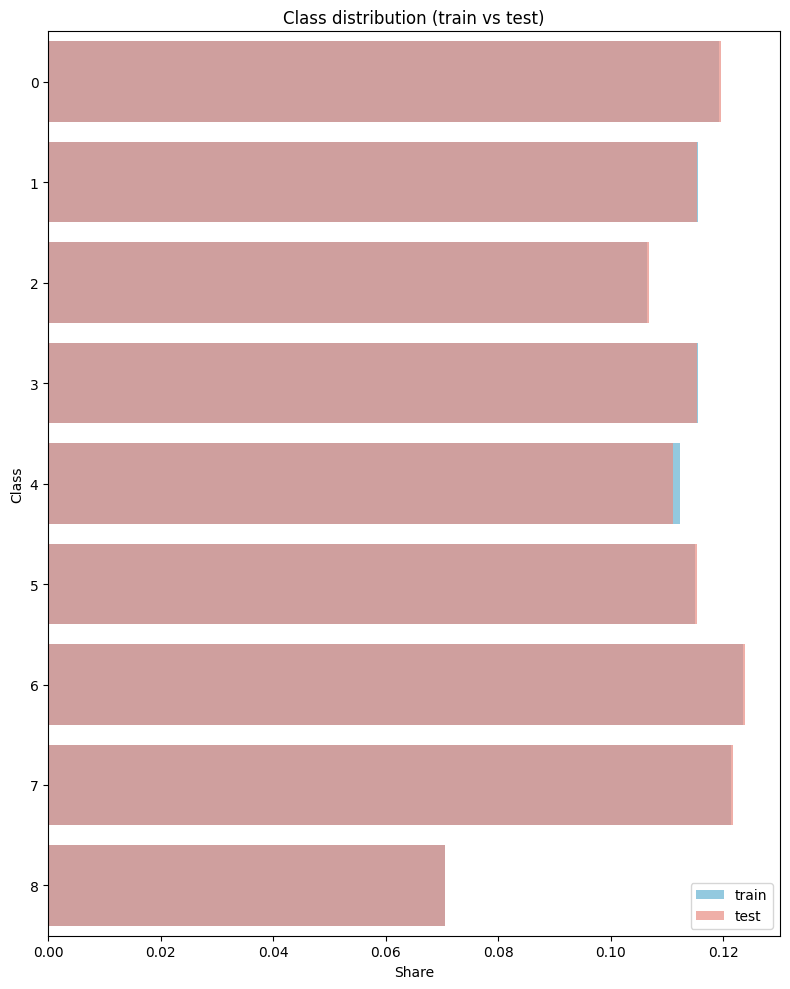

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

le = LabelEncoder()
y_train = le.fit_transform(y_train)   # обучаем кодировщик на трейне
y_test = le.transform(y_test)         # применяем к тесту 

train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_dist  = pd.Series(y_test).value_counts(normalize=True).sort_index()

# Визуализируем
plt.figure(figsize=(8, 10))

sns.barplot(
    y=train_dist.index.astype(str),
    x=train_dist.values,
    color='skyblue',
    label='train'
)

sns.barplot(
    y=test_dist.index.astype(str),
    x=test_dist.values,
    color='salmon',
    alpha=0.7,
    label='test'
)

plt.title("Class distribution (train vs test)")
plt.xlabel("Share")
plt.ylabel("Class")
plt.legend()
plt.tight_layout()
plt.show()

Разбиение данных выполнено со стратификацией, чтобы сохранить одинаковые пропорции классов в обучающей и тестовой выборках.
Судя по графику распределений, доли классов в train и test совпадают.

In [4]:
def evaluate(model, X_tr, y_tr, X_te, y_te, name="model"):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    macro_f1 = f1_score(y_te, y_pred, average="macro", zero_division=0)
    acc = accuracy_score(y_te, y_pred)
    print(f"[{name}] macro-F1={macro_f1:.4f} | accuracy={acc:.4f}")
    print(classification_report(y_te, y_pred, digits=3))
    return macro_f1, acc

Создана вспомогательная функция evaluate(), которая обучает модель, делает предсказания и оценивает её качество.
В качестве метрик используются:
	•	macro F1-score — усреднение F1 по всем классам без учёта их частоты (важно при дисбалансе классов);
	•	accuracy — доля правильных предсказаний.

Функция также выводит подробный classification_report, чтобы увидеть precision, recall и F1 по каждому классу.

In [5]:
dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
_ = evaluate(dummy, X_train, y_train, X_test, y_test, name="Dummy (stratified)")

[Dummy (stratified)] macro-F1=0.1069 | accuracy=0.1090
              precision    recall  f1-score   support

           0      0.107     0.107     0.107        56
           1      0.123     0.130     0.126        54
           2      0.102     0.100     0.101        50
           3      0.070     0.074     0.072        54
           4      0.118     0.115     0.117        52
           5      0.120     0.111     0.115        54
           6      0.123     0.121     0.122        58
           7      0.151     0.140     0.145        57
           8      0.053     0.061     0.056        33

    accuracy                          0.109       468
   macro avg      0.107     0.107     0.107       468
weighted avg      0.110     0.109     0.110       468



Для начала использован самый простой бейзлайн — DummyClassifier(strategy="stratified"), который делает предсказания пропорционально их частотам, примерно как в y_train.value_counts().
Результат ожидаемо низкий: модель не учитывает признаки и служит лишь точкой отсчёта для последующих, более осмысленных моделей.

In [6]:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols),
        ("cat", categorical_preprocess, cat_cols),
    ],
    remainder="drop",
)

Для числовых признаков использована медианная импутация, так как она устойчива к выбросам и сохраняет форму распределения данных лучше, чем среднее значение.
Масштабирование через StandardScaler приводит признаки к одному масштабу , это важно для линейных моделей, которые я в бейзлайне использую. У нас есть данные разных масштабов.

Для категориальных признаков выбран SimpleImputer(strategy="constant", fill_value="Unknown"), чтобы заменить пропуски на отдельную категорию и не терять информацию о пропуске. 
Кодирование выполняется с помощью OneHotEncoder, который создаёт независимые бинарные признаки без предположения о порядке между категориями.
Так как категориальных признаков немного и число уникальных значений в них невелико, использование OHE не приведёт к чрезмерной разреженности матрицы.
Параметр handle_unknown="ignore" обеспечивает устойчивость при появлении новых категорий в тестовых данных.


In [7]:
logreg_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        multi_class="auto",
        class_weight="balanced",
        max_iter=1000,
        random_state=RANDOM_STATE
    )),
])

_ = evaluate(logreg_pipe, X_train, y_train, X_test, y_test, name="LogReg (balanced)")

[LogReg (balanced)] macro-F1=0.1048 | accuracy=0.1239
              precision    recall  f1-score   support

           0      0.151     0.143     0.147        56
           1      0.095     0.037     0.053        54
           2      0.125     0.100     0.111        50
           3      0.080     0.037     0.051        54
           4      0.109     0.096     0.102        52
           5      0.167     0.130     0.146        54
           6      0.125     0.034     0.054        58
           7      0.125     0.053     0.074        57
           8      0.119     0.727     0.205        33

    accuracy                          0.124       468
   macro avg      0.122     0.151     0.105       468
weighted avg      0.122     0.124     0.100       468



/Users/osincevmihail/Study/Maga/ML_course_1_sem/venv310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Логрег сиз коробки справился чуть лучше, чем дамми.

In [8]:
tree_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(
        max_depth=10,                # умеренная глубина для бейзлайна
        min_samples_leaf=20,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

_ = evaluate(tree_pipe, X_train, y_train, X_test, y_test, name="DecisionTree")

[DecisionTree] macro-F1=0.0713 | accuracy=0.0812
              precision    recall  f1-score   support

           0      0.067     0.036     0.047        56
           1      0.000     0.000     0.000        54
           2      0.000     0.000     0.000        50
           3      0.075     0.074     0.075        54
           4      0.102     0.096     0.099        52
           5      0.104     0.185     0.133        54
           6      0.097     0.052     0.067        58
           7      0.100     0.070     0.082        57
           8      0.089     0.303     0.138        33

    accuracy                          0.081       468
   macro avg      0.070     0.091     0.071       468
weighted avg      0.071     0.081     0.069       468



Дерево даже хуже, чем дамми

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
])
_ = evaluate(rf_pipe, X_train, y_train, X_test, y_test, name="RandomForest")

[RandomForest] macro-F1=0.1194 | accuracy=0.1197
              precision    recall  f1-score   support

           0      0.115     0.125     0.120        56
           1      0.109     0.093     0.100        54
           2      0.069     0.080     0.074        50
           3      0.127     0.130     0.128        54
           4      0.132     0.135     0.133        52
           5      0.148     0.148     0.148        54
           6      0.157     0.138     0.147        58
           7      0.111     0.105     0.108        57
           8      0.111     0.121     0.116        33

    accuracy                          0.120       468
   macro avg      0.120     0.119     0.119       468
weighted avg      0.121     0.120     0.120       468



In [10]:
knn_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", KNeighborsClassifier(n_neighbors=25, weights="distance")),
])

_ = evaluate(knn_pipe, X_train, y_train, X_test, y_test, name="KNN (k=25)")

[KNN (k=25)] macro-F1=0.1450 | accuracy=0.1453
              precision    recall  f1-score   support

           0      0.103     0.107     0.105        56
           1      0.207     0.222     0.214        54
           2      0.146     0.140     0.143        50
           3      0.107     0.111     0.109        54
           4      0.106     0.096     0.101        52
           5      0.191     0.167     0.178        54
           6      0.136     0.138     0.137        58
           7      0.169     0.175     0.172        57
           8      0.139     0.152     0.145        33

    accuracy                          0.145       468
   macro avg      0.145     0.145     0.145       468
weighted avg      0.145     0.145     0.145       468



KNN побеждает по макро F1

### Теперь чуть усложним бейзлайн и добавим фичей

In [11]:
rides = pd.read_csv("../data/raw/rides_info.csv")
df = pd.read_csv("../data/raw/car_train.csv")

In [12]:
ride_num_cols = [
    "rating"
]

# ride_num_cols = [
#     "rating", "ride_duration", "ride_cost",
#     "speed_avg", "speed_max", "stop_times",
#     "distance", "user_ride_quality", "deviation_normal"
# ]

rides[ride_num_cols] = rides[ride_num_cols].apply(pd.to_numeric, errors="coerce")

agg = (
    rides
    .groupby("car_id")[ride_num_cols]
    .agg(["mean", "median", "std", "min", "max"])
    .reset_index()
)

agg.columns = ["car_id"] + [f"{c}_{stat}" for c, stat in agg.columns.tolist()[1:]]

agg.head()

,car_id,rating_mean,rating_median,rating_std,rating_min,rating_max
0,A-1049127W,4.255172,4.280,2.291311,0.1,9.53
1,A-1079539w,4.088046,4.290,2.405445,0.1,9.81
2,A-1162143G,4.662299,4.685,1.643052,0.1,9.15
3,A-1228282M,4.225172,4.370,2.176662,0.1,9.36
4,A-1339912r,4.690115,4.680,1.834202,0.1,9.97


In [13]:
df_with_aggs = df.merge(agg, on="car_id", how="inner")

In [14]:
target_col = "target_class"       
id_col = "car_id"   

forbidden = ["target_class", "target_reg", "car_id"]  
feature_cols = [c for c in df_with_aggs.columns if c not in forbidden]
X = df_with_aggs[feature_cols].copy()
y = df_with_aggs["target_class"].astype("category")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [15]:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocess2 = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols),
        ("cat", categorical_preprocess, cat_cols),
    ],
    remainder="drop",
)

logreg_pipe = Pipeline([
    ("prep", preprocess2),
    ("clf", LogisticRegression(
        multi_class="auto",
        class_weight="balanced",
        max_iter=1000,
        random_state=RANDOM_STATE
    )),
])

tree_pipe = Pipeline([
    ("prep", preprocess2),
    ("clf", DecisionTreeClassifier(
        max_depth=10, min_samples_leaf=20,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

rf_pipe = Pipeline([
    ("prep", preprocess2),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
])

knn_pipe = Pipeline([
    ("prep", preprocess2),
    ("clf", KNeighborsClassifier(n_neighbors=25, weights="distance")),
])

In [16]:
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)

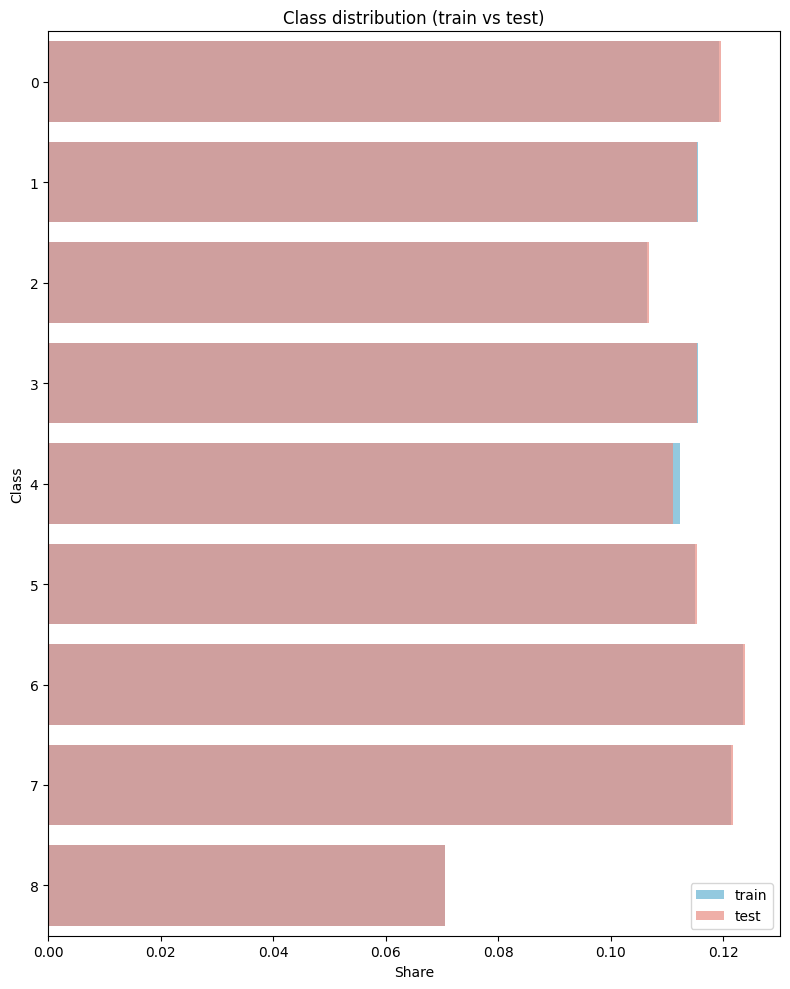

In [17]:
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
test_dist  = pd.Series(y_test).value_counts(normalize=True).sort_index()

# Визуализируем
plt.figure(figsize=(8, 10))

sns.barplot(
    y=train_dist.index.astype(str),
    x=train_dist.values,
    color='skyblue',
    label='train'
)

sns.barplot(
    y=test_dist.index.astype(str),
    x=test_dist.values,
    color='salmon',
    alpha=0.7,
    label='test'
)

plt.title("Class distribution (train vs test)")
plt.xlabel("Share")
plt.ylabel("Class")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
_ = evaluate(logreg_pipe, X_train, y_train, X_test, y_test, name="LogReg (balanced)")

[LogReg (balanced)] macro-F1=0.5391 | accuracy=0.5449
              precision    recall  f1-score   support

           0      0.739     0.607     0.667        56
           1      1.000     1.000     1.000        54
           2      0.980     1.000     0.990        50
           3      0.375     0.167     0.231        54
           4      0.255     0.250     0.252        52
           5      0.270     0.315     0.291        54
           6      0.353     0.310     0.330        58
           7      0.537     0.632     0.581        57
           8      0.393     0.727     0.511        33

    accuracy                          0.545       468
   macro avg      0.545     0.556     0.539       468
weighted avg      0.548     0.545     0.537       468



/Users/osincevmihail/Study/Maga/ML_course_1_sem/venv310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [19]:
_ = evaluate(tree_pipe, X_train, y_train, X_test, y_test, name="DecisionTree")

[DecisionTree] macro-F1=0.5537 | accuracy=0.5491
              precision    recall  f1-score   support

           0      0.745     0.679     0.710        56
           1      1.000     1.000     1.000        54
           2      1.000     1.000     1.000        50
           3      0.333     0.296     0.314        54
           4      0.447     0.404     0.424        52
           5      0.207     0.222     0.214        54
           6      0.302     0.328     0.314        58
           7      0.579     0.386     0.463        57
           8      0.424     0.758     0.543        33

    accuracy                          0.549       468
   macro avg      0.560     0.564     0.554       468
weighted avg      0.561     0.549     0.549       468



In [20]:
_ = evaluate(knn_pipe, X_train, y_train, X_test, y_test, name="KNN (k=25)")

[KNN (k=25)] macro-F1=0.4692 | accuracy=0.4786
              precision    recall  f1-score   support

           0      0.453     0.429     0.440        56
           1      0.981     0.981     0.981        54
           2      0.870     0.940     0.904        50
           3      0.270     0.185     0.220        54
           4      0.273     0.231     0.250        52
           5      0.356     0.389     0.372        54
           6      0.276     0.276     0.276        58
           7      0.417     0.526     0.465        57
           8      0.297     0.333     0.314        33

    accuracy                          0.479       468
   macro avg      0.466     0.477     0.469       468
weighted avg      0.469     0.479     0.472       468



In [21]:
_ = evaluate(rf_pipe, X_train, y_train, X_test, y_test, name="RandomForest (with aggs)")

[RandomForest (with aggs)] macro-F1=0.5406 | accuracy=0.5534
              precision    recall  f1-score   support

           0      0.661     0.732     0.695        56
           1      1.000     1.000     1.000        54
           2      0.980     1.000     0.990        50
           3      0.389     0.259     0.311        54
           4      0.278     0.192     0.227        52
           5      0.317     0.370     0.342        54
           6      0.303     0.345     0.323        58
           7      0.500     0.684     0.578        57
           8      0.500     0.333     0.400        33

    accuracy                          0.553       468
   macro avg      0.548     0.546     0.541       468
weighted avg      0.545     0.553     0.543       468



### Естественно метрики стали намного лучше